In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.utils as utils
import os

In [2]:
import torch.optim as optm
from torchsummary import summary
from tqdm import tqdm

In [3]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [4]:
n_classes = 4

In [5]:
# dataset path
data_path_train = "./data/training"
data_path_test = "./data/testing"

In [6]:
# data transform, you can add different transform methods and resize image to any size
img_size = 224
transform = transforms.Compose([
                       transforms.Resize((img_size,img_size)),
                       transforms.ToTensor()
                       ])

# build dataset
dataset = datasets.ImageFolder(root=data_path_train,transform=transform)

# spilt your data into train and val
TOTAL_SIZE = len(dataset)
ratio = 0.9
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, valid_len])

# build dataloader
train_data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_data_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=True,  num_workers=4)

# check dataset
print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 1646
    Root location: ./data/training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'Baked Potato': 0, 'Crispy Chicken': 1, 'Donut': 2, 'Fries': 3}


## Show Image

In [7]:
examples = next(iter(train_data_loader))

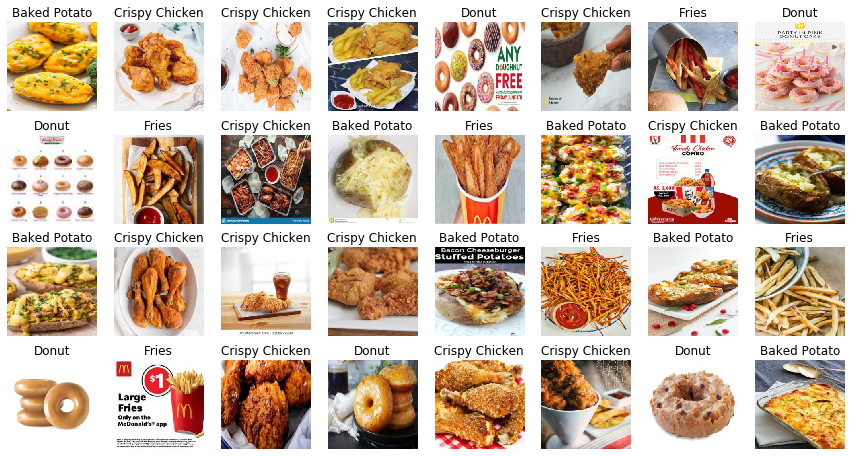

In [8]:
label_list = ["Baked Potato", "Crispy Chicken", "Donut", "Fries"]

fig = plt.figure(figsize=(15,10))
for idx, img in enumerate(examples[0]):
    ax = fig.add_subplot(5, 8, idx+1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"{label_list[examples[1][idx]]}")
    plt.axis('off')

## Train & Validation

In [9]:
#train function
def train(model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in train_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data)
        
    avg_loss = total_loss / len(train_data_loader)
    accuracy = total_correct.double() / len(train_dataset) * 100

    print('Train Acc: {:.4f}%, Train Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy, avg_loss

#validation function
def valid(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in val_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data)
        
    avg_loss = total_loss / len(val_data_loader)
    accuracy = total_correct.double() / len(val_dataset) * 100

    print('Valid Acc: {:.4f}%, Valid Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy, avg_loss

## Residual Block

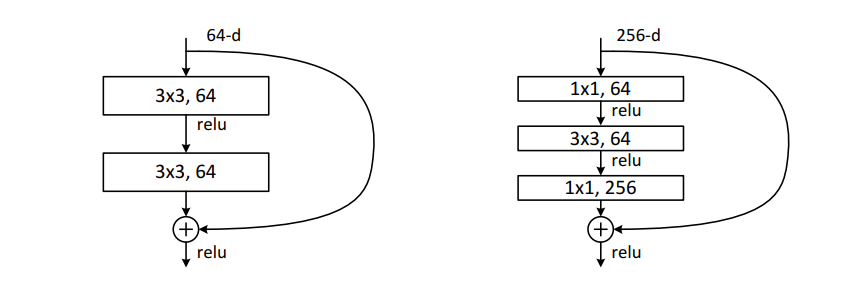

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(BasicBlock, self).__init__()
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if self.stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(x)
        out = self.relu(out)
        
        return out

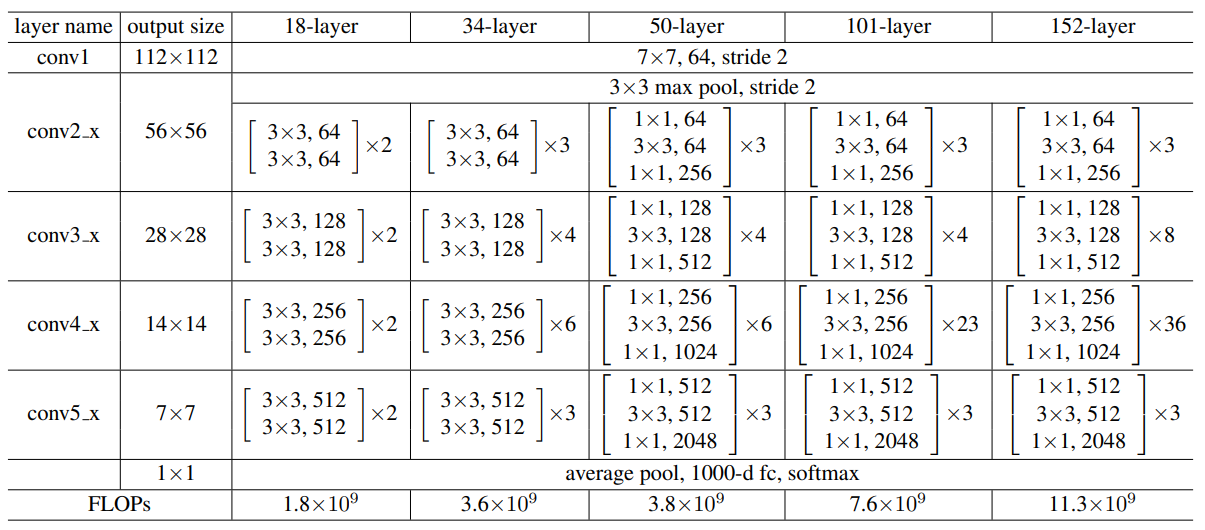

## ResNet

In [11]:
class ResNet18(nn.Module):
    def __init__(self, n_classes=4):
        super(ResNet18, self).__init__()
        self.in_ch = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, n_classes)
        
    def _make_layer(self, block, out_ch, blocks, stride=1):
        layers = []
        layers.append(block(self.in_ch, out_ch, stride))
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(block(self.in_ch, out_ch, stride=1))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [12]:
# call model
model = ResNet18()

In [13]:
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|  

In [15]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
lr = 1e-3
epochs = 100
optimizer = optm.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


# start training
model.to(device=device)
acc_best = 0.0

history_train_loss, history_train_acc= [], []
history_val_loss, history_val_acc = [], []

print('--------------start training--------------')
for epoch in range(1, epochs+1):
    
    print(f'epoch: {epoch}/{epochs}')
    train_acc, train_loss = train(model, criterion, optimizer)
    val_acc, val_loss = valid(model, criterion)
    
    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc)
    history_val_loss.append(val_loss)
    history_val_acc.append(val_acc)
    
    if val_acc > acc_best:
        acc_best = val_acc
        print("model saved")
        # save the model
        torch.save(model, "model.pth")
    
    print('-------------------------------------')

--------------start training--------------
epoch: 1/100
Train Acc: 49.3585%, Train Loss: 1.2484
Valid Acc: 46.0606%, Valid Loss: 1.3994
model saved
-------------------------------------
epoch: 2/100
Train Acc: 61.1749%, Train Loss: 0.9593
Valid Acc: 33.3333%, Valid Loss: 1.7811
-------------------------------------
epoch: 3/100
Train Acc: 61.1749%, Train Loss: 0.9394
Valid Acc: 69.0909%, Valid Loss: 0.8194
model saved
-------------------------------------
epoch: 4/100
Train Acc: 67.1843%, Train Loss: 0.8493
Valid Acc: 44.2424%, Valid Loss: 2.8575
-------------------------------------
epoch: 5/100
Train Acc: 68.3322%, Train Loss: 0.8152
Valid Acc: 68.4848%, Valid Loss: 0.8450
-------------------------------------
epoch: 6/100
Train Acc: 71.6408%, Train Loss: 0.7509
Valid Acc: 69.0909%, Valid Loss: 0.9040
-------------------------------------
epoch: 7/100
Train Acc: 72.3160%, Train Loss: 0.7446
Valid Acc: 73.9394%, Valid Loss: 0.7225
model saved
-------------------------------------
epoc

Valid Acc: 76.3636%, Valid Loss: 1.0299
-------------------------------------
epoch: 63/100
Train Acc: 96.0837%, Train Loss: 0.1162
Valid Acc: 71.5152%, Valid Loss: 2.5301
-------------------------------------
epoch: 64/100
Train Acc: 96.1512%, Train Loss: 0.1098
Valid Acc: 83.0303%, Valid Loss: 0.6322
-------------------------------------
epoch: 65/100
Train Acc: 98.9872%, Train Loss: 0.0304
Valid Acc: 80.0000%, Valid Loss: 0.7549
-------------------------------------
epoch: 66/100
Train Acc: 99.3923%, Train Loss: 0.0208
Valid Acc: 76.3636%, Valid Loss: 1.1316
-------------------------------------
epoch: 67/100
Train Acc: 99.2573%, Train Loss: 0.0234
Valid Acc: 73.3333%, Valid Loss: 1.2148
-------------------------------------
epoch: 68/100
Train Acc: 99.7299%, Train Loss: 0.0153
Valid Acc: 82.4242%, Valid Loss: 0.9429
-------------------------------------
epoch: 69/100
Train Acc: 98.8521%, Train Loss: 0.0315
Valid Acc: 69.6970%, Valid Loss: 1.4373
------------------------------------

In [16]:
print(f"Best Validation Acc: {acc_best.cpu():.2f}%")

Best Validation Acc: 83.64%


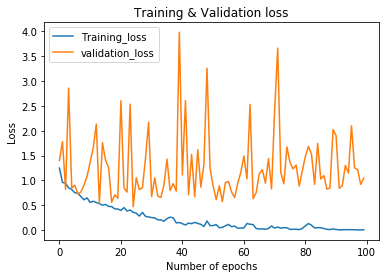

In [41]:
plt.plot(history_train_loss, label='Training_loss')
plt.plot(history_val_loss, label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

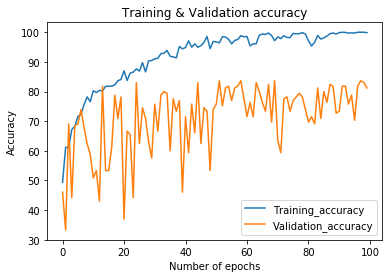

In [42]:
plt.plot(history_train_acc, label='Training_accuracy')
plt.plot(history_val_acc, label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Pre-train ResNet18

In [19]:
model_pre = models.resnet18(pretrained=True)

In [20]:
in_features = model_pre.fc.in_features
model_pre.fc = nn.Linear(in_features, n_classes)

In [21]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
lr = 1e-3
epochs = 100
optimizer = optm.Adam(model_pre.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


# start training
model_pre.to(device=device)
acc_best = 0.0

history_pre_train_loss, history_pre_train_acc= [], []
history_pre_val_loss, history_pre_val_acc = [], []

print('=========== Pre-train ResNet18 ==========')
print('--------------start training--------------')
for epoch in range(1, epochs+1):
    
    print(f'epoch: {epoch}/{epochs}')
    train_acc, train_loss = train(model_pre, criterion, optimizer)
    val_acc, val_loss = valid(model_pre, criterion)
    
    history_pre_train_loss.append(train_loss)
    history_pre_train_acc.append(train_acc)
    history_pre_val_loss.append(val_loss)
    history_pre_val_acc.append(val_acc)
    
    if val_acc > acc_best:
        pre_acc_best = val_acc
        print("model saved")
        # save the model
        torch.save(model_pre, "model_pre.pth")
    
    print('-------------------------------------')

=========== Pre-train ResNet18 ==========
--------------start training--------------
epoch: 1/100
Train Acc: 82.2417%, Train Loss: 0.5334
Valid Acc: 57.5758%, Valid Loss: 3.4549
model saved
-------------------------------------
epoch: 2/100
Train Acc: 89.0614%, Train Loss: 0.3218
Valid Acc: 80.6061%, Valid Loss: 0.6213
model saved
-------------------------------------
epoch: 3/100
Train Acc: 91.7623%, Train Loss: 0.2390
Valid Acc: 84.2424%, Valid Loss: 0.5867
model saved
-------------------------------------
epoch: 4/100
Train Acc: 93.9230%, Train Loss: 0.1660
Valid Acc: 78.7879%, Valid Loss: 0.6688
model saved
-------------------------------------
epoch: 5/100
Train Acc: 93.9230%, Train Loss: 0.1607
Valid Acc: 85.4545%, Valid Loss: 0.4936
model saved
-------------------------------------
epoch: 6/100
Train Acc: 95.6786%, Train Loss: 0.1335
Valid Acc: 88.4848%, Valid Loss: 0.4459
model saved
-------------------------------------
epoch: 7/100
Train Acc: 94.0581%, Train Loss: 0.1906
Vali

Valid Acc: 89.0909%, Valid Loss: 0.5453
model saved
-------------------------------------
epoch: 58/100
Train Acc: 99.8650%, Train Loss: 0.0079
Valid Acc: 88.4848%, Valid Loss: 0.3396
model saved
-------------------------------------
epoch: 59/100
Train Acc: 99.5949%, Train Loss: 0.0124
Valid Acc: 86.6667%, Valid Loss: 0.3988
model saved
-------------------------------------
epoch: 60/100
Train Acc: 99.7974%, Train Loss: 0.0070
Valid Acc: 87.8788%, Valid Loss: 0.4579
model saved
-------------------------------------
epoch: 61/100
Train Acc: 99.7299%, Train Loss: 0.0098
Valid Acc: 89.0909%, Valid Loss: 0.3047
model saved
-------------------------------------
epoch: 62/100
Train Acc: 99.2573%, Train Loss: 0.0229
Valid Acc: 88.4848%, Valid Loss: 0.4070
model saved
-------------------------------------
epoch: 63/100
Train Acc: 99.3248%, Train Loss: 0.0197
Valid Acc: 85.4545%, Valid Loss: 0.5157
model saved
-------------------------------------
epoch: 64/100
Train Acc: 97.4342%, Train Loss:

In [23]:
print(f"Best Validation Acc (pre-train): {pre_acc_best.cpu():.2f}%")

Best Validation Acc (pre-train): 89.70%


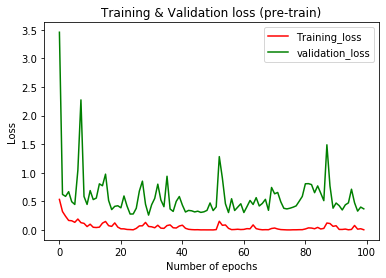

In [30]:
plt.plot(history_pre_train_loss, color='red', label='Training_loss')
plt.plot(history_pre_val_loss, color='green', label='validation_loss')
plt.title('Training & Validation loss (pre-train)')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

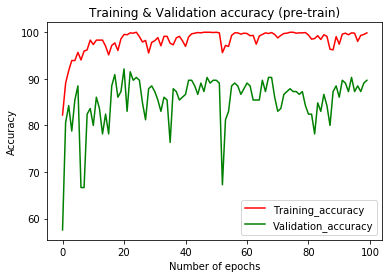

In [31]:
plt.plot(history_pre_train_acc, color='red', label='Training_accuracy')
plt.plot(history_pre_val_acc, color='green', label='Validation_accuracy')
plt.title('Training & Validation accuracy (pre-train)')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Comparison

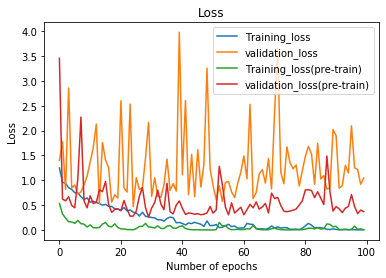

In [40]:
plt.plot(history_train_loss, label='Training_loss')
plt.plot(history_val_loss, label='validation_loss')
plt.plot(history_pre_train_loss, label='Training_loss(pre-train)')
plt.plot(history_pre_val_loss, label='validation_loss(pre-train)')
plt.title('Loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

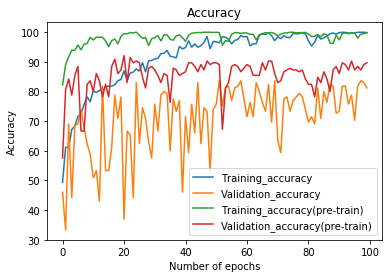

In [39]:
plt.plot(history_train_acc, label='Training_accuracy')
plt.plot(history_val_acc, label='Validation_accuracy')
plt.plot(history_pre_train_acc, label='Training_accuracy(pre-train)')
plt.plot(history_pre_val_acc, label='Validation_accuracy(pre-train)')
plt.title('Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb